In [89]:
import math
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from helpers import get_error_rate
from IPython.display import display
from matplotlib.pyplot import figure
from qiskit import IBMQ, QuantumCircuit, transpile
from qiskit.circuit.library import CXGate, RZGate, SXGate, XGate
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
import os
import seaborn as sns
import pandas as pd

In [90]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-27 00:06:18,016: Credentials are already in use. The existing account in the session will be replaced.


In [91]:
#hw = least_busy(provider.backends(n_qubits=5, simulator=False, operational=True))
hw = provider.get_backend("ibmq_lima")

In [92]:
hw.name()

'ibmq_lima'

In [93]:
def add_random_gate(qc: QuantumCircuit, hw=None):
	param = random.uniform(0,2) * math.pi
	gates = [RZGate(param), SXGate(), XGate(), CXGate()]#, IGate()]
	gate = random.choice(gates)
	n_qubits = qc.num_qubits
	if isinstance(gate, CXGate):
		if hw:
			target = random.choice(hw.configuration().coupling_map)
		else:
			target = random.sample(range(n_qubits), k=2)
		qc.append(gate, target)
	else:
		target = random.choice(list(range(n_qubits)))
		qc.append(gate, [target])

	return qc

In [94]:
def get_circuit_with_length(hw, length=2):
	samples = np.linspace(np.ceil(length/2), length*3, length*5, dtype=int)
	n_qubits = hw.configuration().n_qubits
	for i in range(1000):
		circuits = []
		for sample in samples:
			qc = QuantumCircuit(n_qubits, n_qubits)
			qc_tmp = QuantumCircuit(n_qubits, n_qubits)
			for j in range(sample):
				qc_tmp = add_random_gate(qc_tmp, hw)
			qc.barrier()
			qc.append(qc_tmp, range(n_qubits), range(n_qubits))
			qc.barrier(range(n_qubits))
			qc.append(qc_tmp.inverse(), range(n_qubits), range(n_qubits))
			qc.barrier()
			qc.measure_all(add_bits=False)
			circuits.append(qc)
		c_t = transpile(circuits, hw, optimization_level=0)
		depths = np.array([c.depth() - 1 for c in c_t])
		if length in depths:
			idx = np.nonzero(depths == length)[0]
			choosen_idx = random.choice(idx)
			assert c_t[choosen_idx].depth() - 1 == length
			return c_t[choosen_idx]
		else:
			pass
		
	raise Exception("no circuit found")

In [95]:
def create_test_circuits(hw, start, step, end, samples_per_step):
	samples = np.arange(start, end, step, dtype=int)
	circs_samples = {}
	for sample in samples:
		circuits = []
		for i in range(samples_per_step):
			qc = get_circuit_with_length(hw, sample)
			circuits.append(qc)
		circs_samples[sample] = circuits
	return circs_samples

In [96]:
if os.path.isfile("more_detailed_error_all.pickle"):
	with open("more_detailed_error_all.pickle", "rb") as file:
		circs_samples_all, jobs_samples_all, circs_result_all, noise_model = pickle.load(file)
else:
	circ_samples = create_test_circuits(hw, 2, 2, 11, 100)
	circ_sample_next = create_test_circuits(hw, 12, 2, 21, 100)
	jobs_samples = {}
	for k, v in circ_samples.items():
		jobs_samples[k] = hw.run(v).job_id()

	for v in jobs_samples.values():
		v.result()

	jobs_samples_next = {}
	for k, v in circ_sample_next.items():	
		jobs_samples_next[k] = hw.run(v).job_id()

	jobs_samples_all = jobs_samples | jobs_samples_next
	circs_result_all = {}
	for k, v in jobs_samples_all.items():
		circs_result_all[k] = hw.retrieve_job(v).result().get_counts()

	noise_model = NoiseModel.from_backend(hw)
	circs_samples_all = circ_samples | circ_sample_next
	with open("more_detailed_error_all.pickle", "wb") as file:
		pickle.dump((circs_samples_all, jobs_samples_all, circs_result_all, noise_model), file)

In [97]:
circs_errors = {}
for k, v in circs_result_all.items():
	circs_errors[k] = np.array([get_error_rate(r, {"00000" : 1}) for r in v])*100

In [98]:
sim = AerSimulator(noise_model=noise_model)
sim_results_all = {}
for k, v in circs_samples_all.items():
	sim_results_all[k] = sim.run(v).result().get_counts()
sim_errors = {}
for k, v in sim_results_all.items():
	sim_errors[k] = np.array([get_error_rate(r, {"00000" : 1}) for r in v])*100

In [99]:
# load improved noise model from the structured search
with open("updated_improved_noise_model.pickle", "rb") as file:
	improved_noise_model = pickle.load(file)

In [100]:
sim_improved = AerSimulator(noise_model=improved_noise_model)
sim_imporved_results_all = {}
for k, v in circs_samples_all.items():
	sim_imporved_results_all[k] = sim_improved.run(v).result().get_counts()
sim_imporved_errors = {}
for k, v in sim_imporved_results_all.items():
	sim_imporved_errors[k] = np.array([get_error_rate(r, {"00000" : 1}) for r in v])*100

In [101]:
means = []
means_x = []
for k, v in circs_errors.items():
	means_x.append(k)
	means.append(v.mean())
means_sim = []
means_sim_x = []
for k, v in sim_errors.items():
	means_sim_x.append(k)
	means_sim.append(v.mean())
means_sim_x_np = np.array(means_sim_x)
means_sim_improved = []
means_sim_improved_x = []
for k, v in sim_imporved_errors.items():
	means_sim_improved_x.append(k)
	means_sim_improved.append(v.mean())
means_sim_improved_x_np = np.array(means_sim_improved_x)

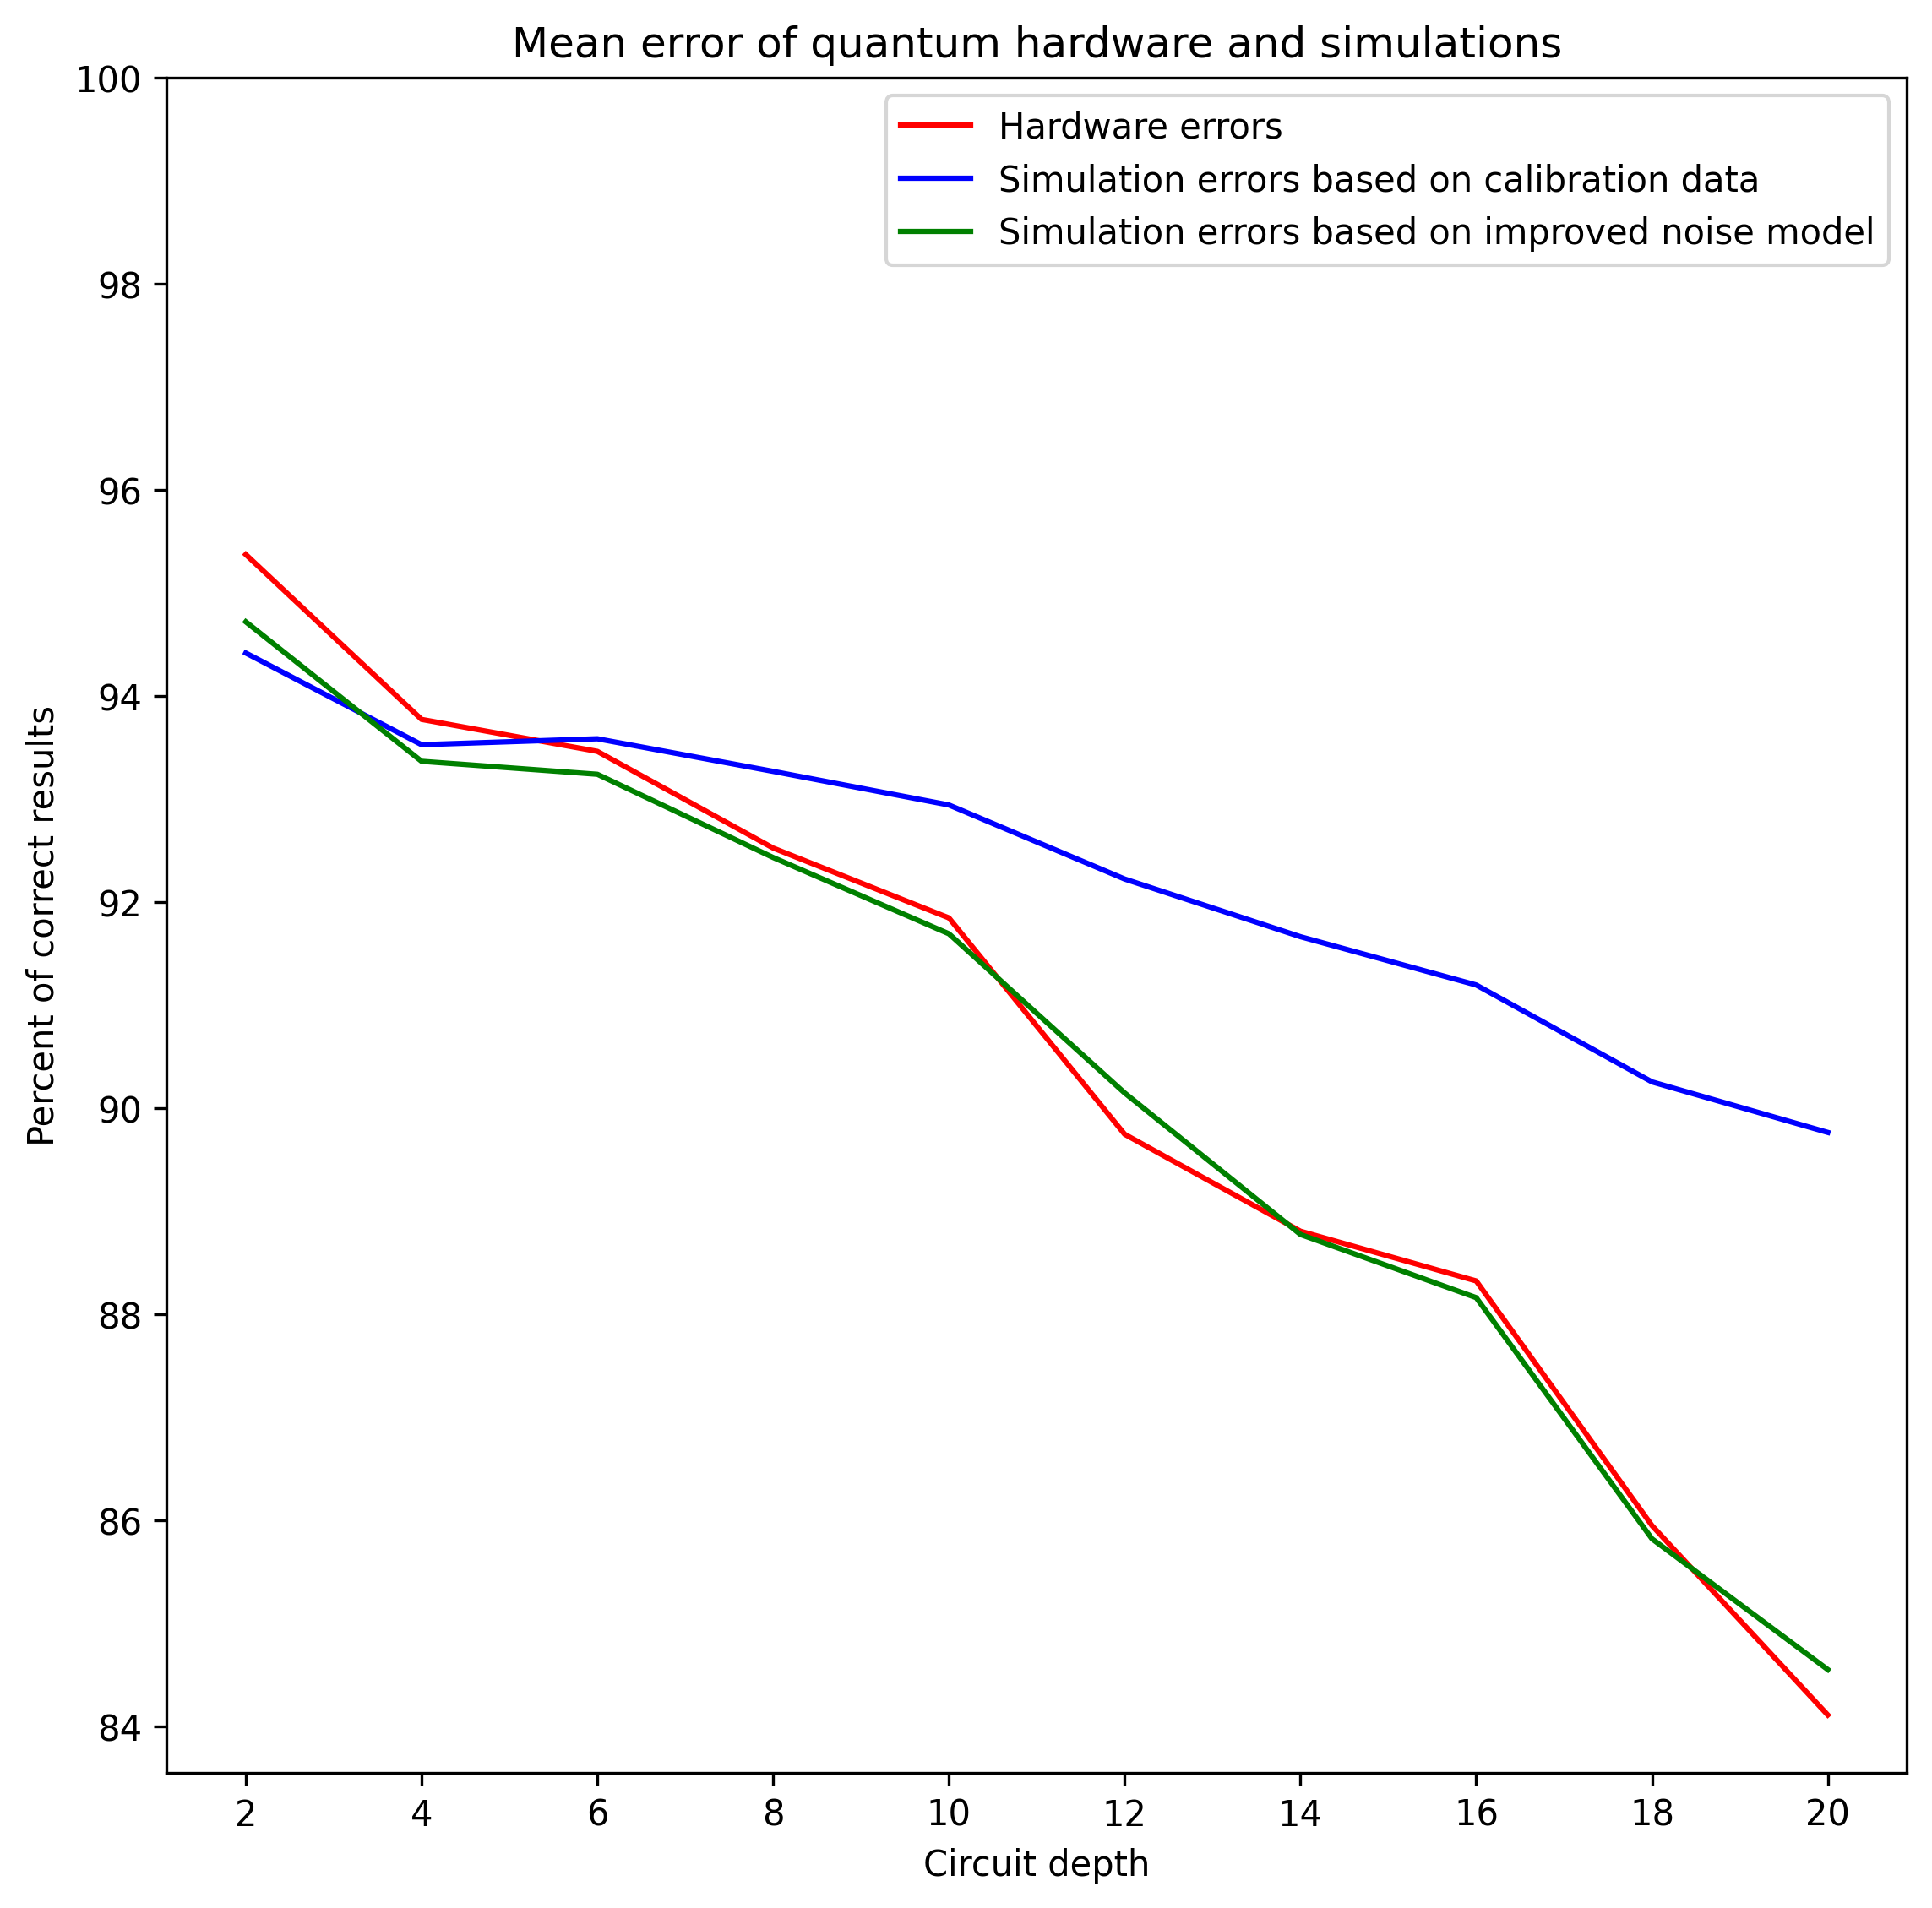

None

In [102]:
factor = 3
figure_width = 5.90666*factor/2
figure_heigth = figure_width
dpi = 300
figure(figsize=(figure_width, figure_heigth), dpi=dpi)
plt.title(f"Mean error of quantum hardware and simulations")
plt.xlabel(f"Circuit depth")
plt.ylabel(f"Percent of correct results")
# for k, v in circs_errors.items():
# 	plt.plot([k]*len(v), v, color="red", label="Hardware errors")
plt.plot(means_x, means, color="red", label="Hardware errors")

# for k, v in sim_errors.items():
# 	plt.plot([k+0.2]*len(v), v, color="blue", label="Simulation errors based on calibration data")
plt.plot(means_sim_x_np, means_sim, color="blue", label="Simulation errors based on calibration data")

# for k, v in sim_imporved_errors.items():
# 	plt.plot([k+0.4]*len(v), v, color="green", label="Simulation based on improved noise model")
plt.plot(means_sim_improved_x_np, means_sim_improved, color="green", label="Simulation errors based on improved noise model")

plt.xticks(list(circs_errors.keys()))
plt.ylim(top=100)

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.savefig(f"../images/error_rates_hw_sim_improved_sim.png", bbox_inches='tight')
display(plt.show())

In [103]:
data = pd.DataFrame({"Quantum hardware": circs_errors[k], "Improved noise model": sim_imporved_errors[k], "Noise model based on calibration data": sim_errors[k]})

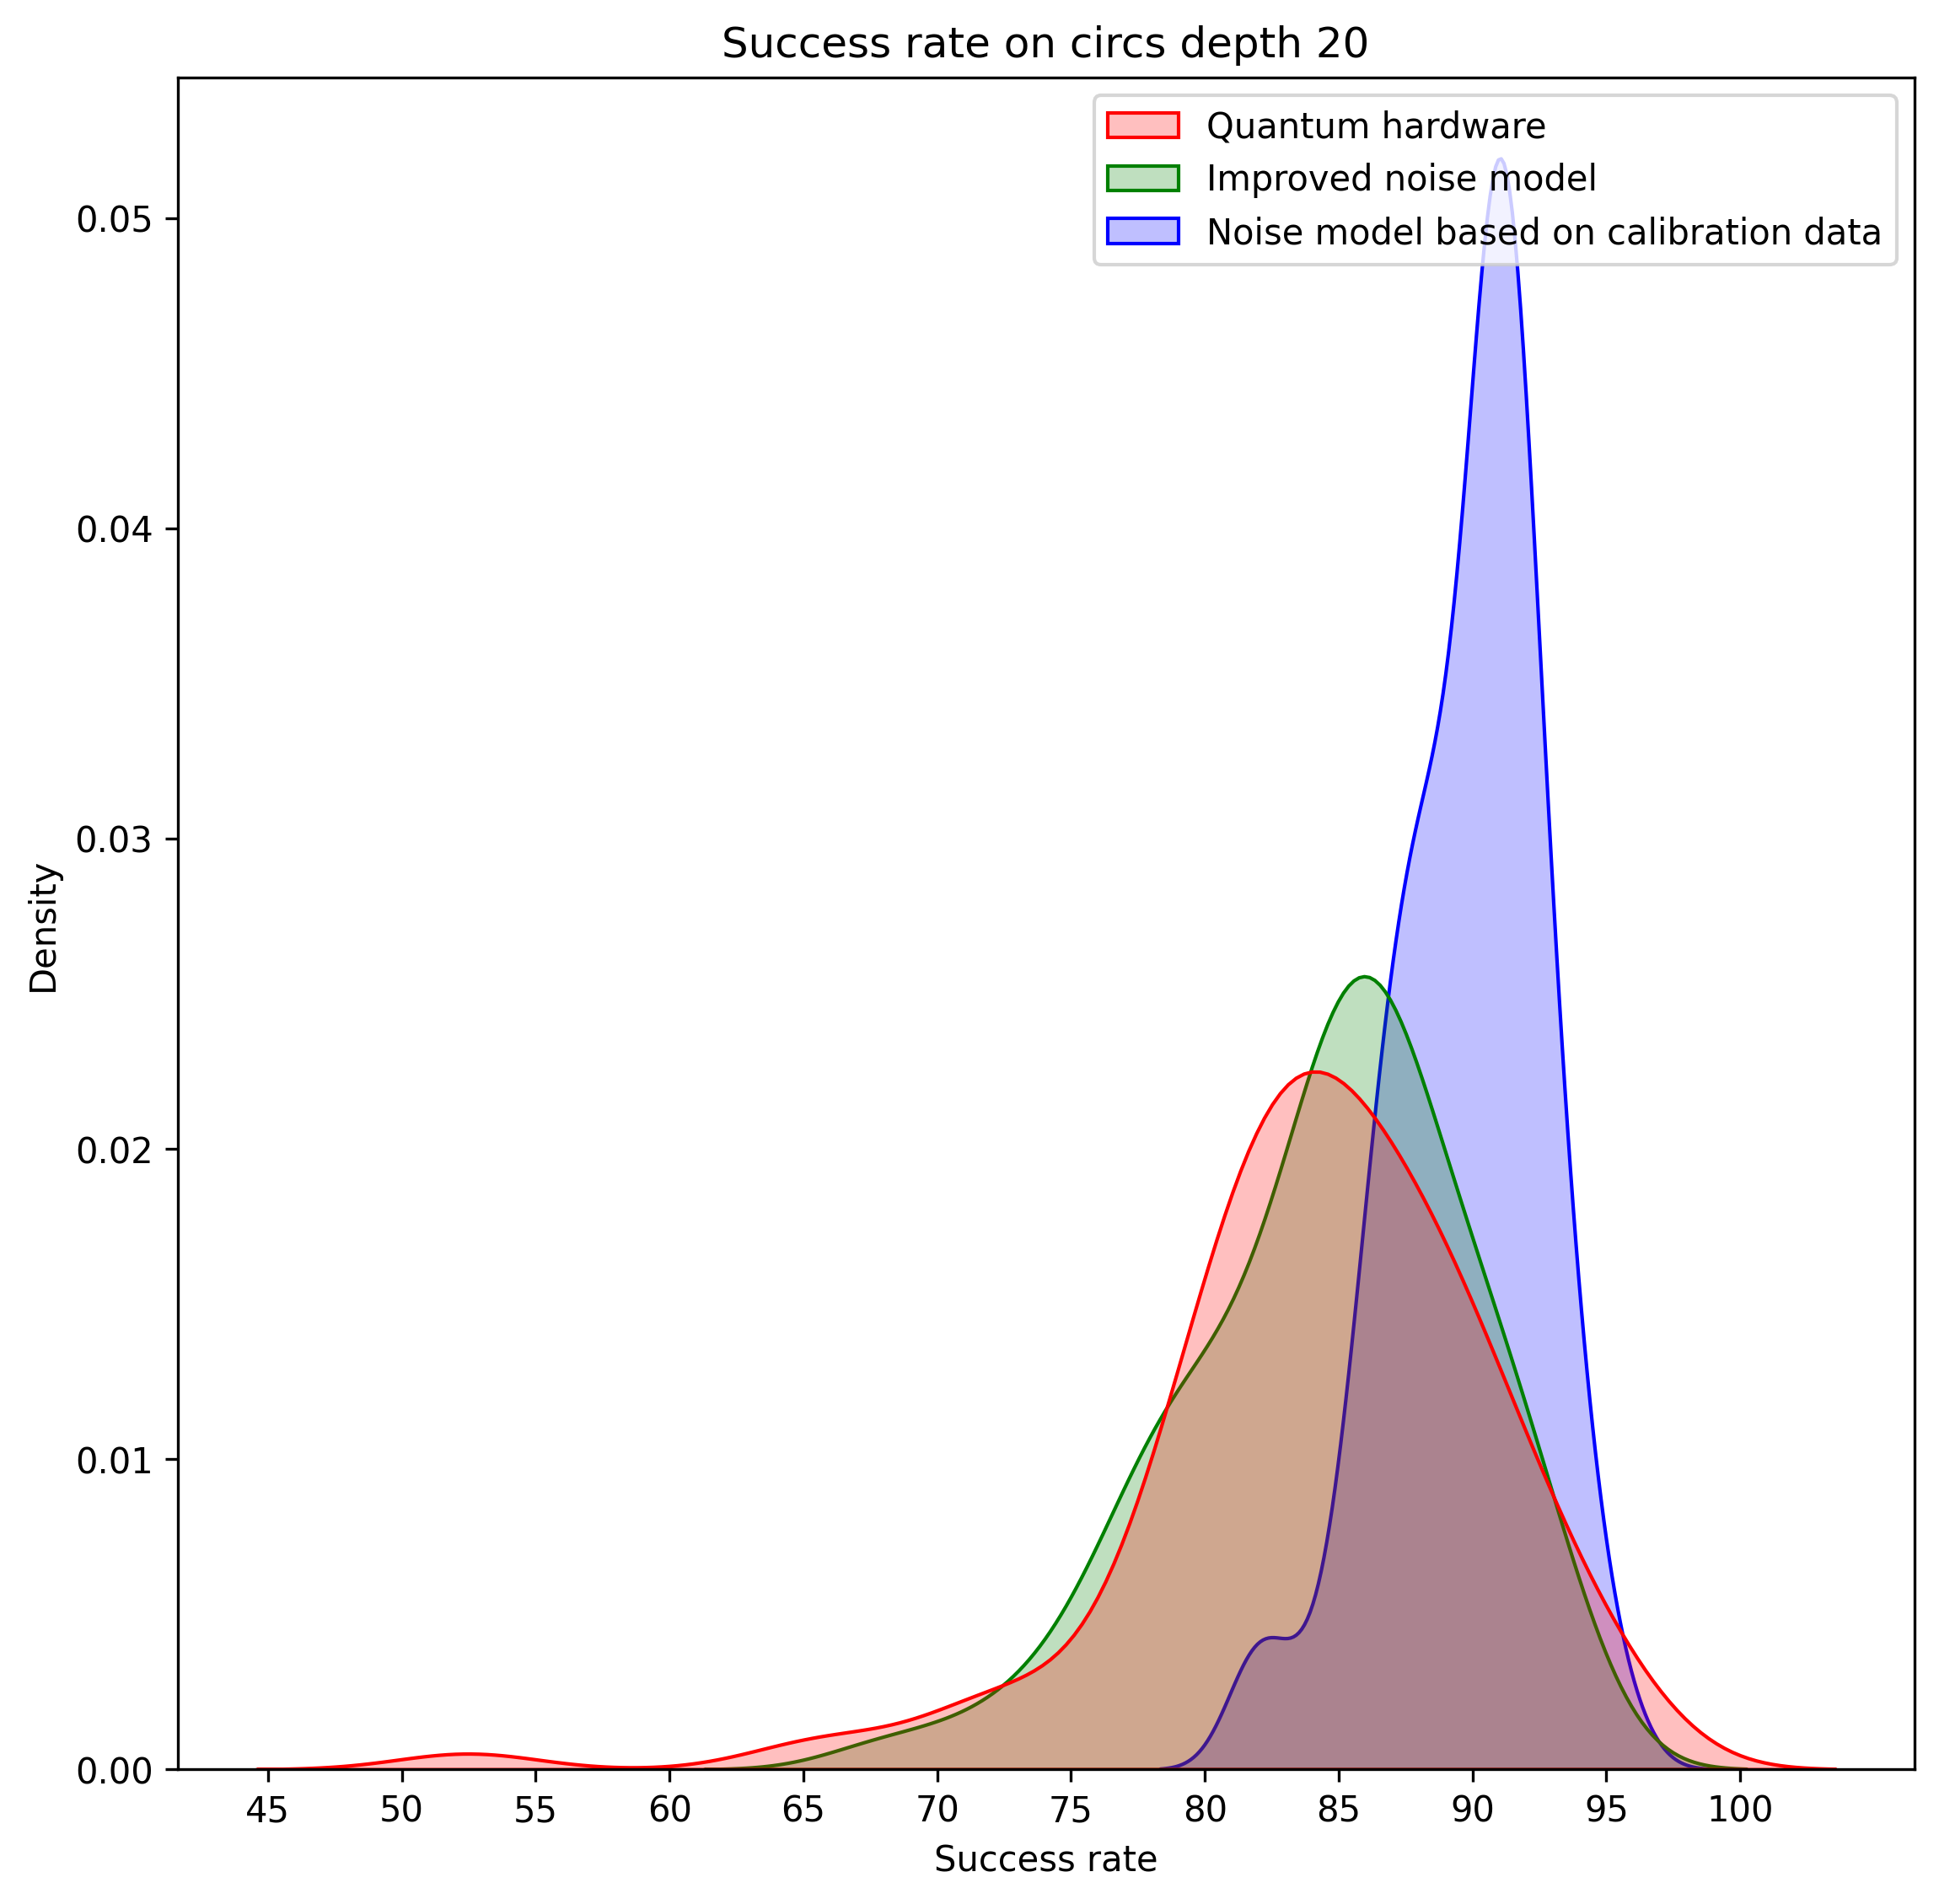

None

In [104]:
# for k in circs_errors.keys():
k = 20
factor = 3
figure_width = 5.90666*factor/2
figure_heigth = figure_width
dpi = 300
figure(figsize=(figure_width, figure_heigth), dpi=dpi)	
plt.title(f"Success rate on circs depth {k}")
sns.kdeplot(data=data, palette=["red", "green", "blue"], bw_adjust=1, fill=True)
plt.xlabel("Success rate")
plt.xticks(np.arange(45, 101, 5))
plt.savefig(f"../images/error_rates_hw_sim_improved_sim_distirbution_{k}.png", bbox_inches='tight')
display(plt.show())